#Тема «POS-tagger и NER»

##Задание 1. Написать теггер на данных с русским языком
1. Проверить UnigramTagger, BigramTagger, TrigramTagger и их комбинации.
2. Написать свой теггер как на занятии, попробовать разные векторайзеры, добавить знание не только букв но и слов
3. Сравнить все реализованные методы, сделать выводы
 
##Задание 2. Проверить, насколько хорошо работает NER
###Данные брать из http://www.labinform.ru/pub/named_entities/
1. Проверить NER из nltk/spacy/deeppavlov.
2. Написать свой NER, попробовать разные подходы:
- передаём в сетку токен и его соседей.
- передаём в сетку только токен.
- свой вариант.
3. Сравнить свои реализованные подходы на качество — вывести precision/recall/f1_score.


In [1]:
! pip install pyconll

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
from nltk.tag import DefaultTagger
from nltk.tag import UnigramTagger
from nltk.tag import BigramTagger, TrigramTagger
from nltk.tag import RegexpTagger
import pandas as pd
import numpy as np
import pyconll

In [11]:
!wget -O ./ru_syntagrus-ud-train.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-a.conllu -P datasets
!wget -O ./ru_syntagrus-ud-dev.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-dev.conllu -P datasets

--2022-08-18 20:29:09--  https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-a.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40736565 (39M) [text/plain]
Saving to: ‘./ru_syntagrus-ud-train.conllu’

agrus-ud-train.conl 100%[===================>]  38.85M   189MB/s    in 0.2s    

2022-08-18 20:29:10 (189 MB/s) - ‘./ru_syntagrus-ud-train.conllu’ saved [40736565/40736565]

--2022-08-18 20:29:10--  https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-dev.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199

In [12]:
full_train = pyconll.load_from_file('ru_syntagrus-ud-train.conllu')
full_test = pyconll.load_from_file('ru_syntagrus-ud-dev.conllu')

In [16]:
for sent in full_train[:2]:
    for token in sent:
        print(token.form, token.upos)
    print()

Анкета NOUN
. PUNCT

Начальник NOUN
областного ADJ
управления NOUN
связи NOUN
Семен PROPN
Еремеевич PROPN
был AUX
человек NOUN
простой ADJ
, PUNCT
приходил VERB
на ADP
работу NOUN
всегда ADV
вовремя ADV
, PUNCT
здоровался VERB
с ADP
секретаршей NOUN
за ADP
руку NOUN
и CCONJ
иногда ADV
даже PART
писал VERB
в ADP
стенгазету NOUN
заметки NOUN
под ADP
псевдонимом NOUN
" PUNCT
Муха NOUN
" PUNCT
. PUNCT



In [17]:
fdata_train = []
for sent in full_train[:]:
    fdata_train.append([(token.form, token.upos) for token in sent])
    
fdata_test = []
for sent in full_test[:]:
    fdata_test.append([(token.form, token.upos) for token in sent])
    
fdata_sent_test = []
for sent in full_test[:]:
    fdata_sent_test.append([token.form for token in sent])

In [18]:
MAX_SENT_LEN = max(len(sent) for sent in full_train)
MAX_ORIG_TOKEN_LEN = max(len(token.form) for sent in full_train for token in sent)
print('Наибольшая длина предложения', MAX_SENT_LEN)
print('Наибольшая длина токена', MAX_ORIG_TOKEN_LEN)

Наибольшая длина предложения 194
Наибольшая длина токена 31


In [44]:
all_train_texts = [' '.join(token.form for token in sent) for sent in full_train]
all_test_texts = [' '.join(token.form for token in sent if token.form is not None) for sent in full_test]

print('\n'.join(all_train_texts[:10]))

Анкета .
Начальник областного управления связи Семен Еремеевич был человек простой , приходил на работу всегда вовремя , здоровался с секретаршей за руку и иногда даже писал в стенгазету заметки под псевдонимом " Муха " .
В приемной его с утра ожидали посетители , - кое-кто с важными делами , а кое-кто и с такими , которые легко можно было решить в нижестоящих инстанциях , не затрудняя Семена Еремеевича .
Однако стиль работы Семена Еремеевича заключался в том , чтобы принимать всех желающих и лично вникать в дело .
Приемная была обставлена просто , но по-деловому .
У двери стоял стол секретарши , на столе - пишущая машинка с широкой кареткой .
В углу висел репродуктор и играло радио для развлечения ожидающих и еще для того , чтобы заглушать голос начальника , доносившийся из кабинета , так как , бесспорно , среди посетителей могли находиться и случайные люди .
Кабинет отличался скромностью , присущей Семену Еремеевичу .
В глубине стоял широкий письменный стол с бронзовыми чернильницами

Проверим сначала UnigramTagger:

In [45]:
unigram_tagger = UnigramTagger(fdata_train)
display(unigram_tagger.evaluate(fdata_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  


0.823732013802982

Довольно неплохо. Попробуем BigramTagger:

In [48]:
bigram_tagger = BigramTagger(fdata_train)
display(bigram_tagger.evaluate(fdata_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  


0.6093886320724006

Стало сильно хуже. Теперь попробуем комбинацию BigramTagger и UnigramTagger:

In [50]:
bigram_tagger_back = BigramTagger(fdata_train, backoff=unigram_tagger)
display(bigram_tagger_back.evaluate(fdata_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  


0.8292792499511688

Метрика выросла в третьем знаке. Попробуем отдельно TrigramTagger:

In [51]:
trigram_tagger = TrigramTagger(fdata_train)
display(trigram_tagger.evaluate(fdata_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  


0.1778631421316492

Совсем плохо. Попробуем комбинацию всех трех теггеров:

In [52]:
trigram_tagger_back = TrigramTagger(fdata_train, backoff=bigram_tagger_back)
display(trigram_tagger_back.evaluate(fdata_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  


0.8291425222996289

Второе место по метрике. 

**Вывод:**

С этой задачей лучше всего справляется комбинация BigramTagger и UnigramTagger

Составим свой датасет, добавив метку отсутствия тега:

In [53]:
train_tok = []
train_label = []
for sent in fdata_train[:]:
    for tok in sent:
        train_tok.append(tok[0])
        train_label.append('NO_TAG' if tok[1] is None else tok[1])
        
test_tok = []
test_label = []
for sent in fdata_test[:]:
    for tok in sent:
        if tok[0] is not None:
            test_tok.append(tok[0])
            test_label.append('NO_TAG' if tok[1] is None else tok[1])

In [55]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [56]:
le = LabelEncoder()
train_enc_labels = le.fit_transform(train_label)
test_enc_labels = le.transform(test_label)
le.classes_

array(['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN',
       'NO_TAG', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM',
       'VERB', 'X'], dtype='<U6')

Попробуем проанализировать CountVectorizer n-граммы букв от 2 до 5:

In [57]:
cntvectorizer = CountVectorizer(ngram_range=(2, 5), analyzer='char')
X_train = cntvectorizer.fit_transform(train_tok)
X_test = cntvectorizer.transform(test_tok)
lr = LogisticRegression(random_state=0, max_iter=10)
lr.fit(X_train, train_enc_labels)
pred = lr.predict(X_test)
accuracy_score(test_enc_labels, pred)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.7412801490272196

Неплохо, но nltk справляется лучше. Возьмем n-граммы от 1 до 3:

In [58]:
cntvectorizer = CountVectorizer(ngram_range=(1, 3), analyzer='char')
X_train = cntvectorizer.fit_transform(train_tok)
X_test = cntvectorizer.transform(test_tok)
lr = LogisticRegression(random_state=0, max_iter=10)
lr.fit(X_train, train_enc_labels)
pred = lr.predict(X_test)
accuracy_score(test_enc_labels, pred)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.747624227344671

В 3-м знаке метрика повысилась. Максимальная метрика получается при n-граммах от 1 до 7:

In [63]:
cntvectorizer = CountVectorizer(ngram_range=(1, 7), analyzer='char')
X_train = cntvectorizer.fit_transform(train_tok)
X_test = cntvectorizer.transform(test_tok)
lr = LogisticRegression(random_state=0, max_iter=10)
lr.fit(X_train, train_enc_labels)
pred = lr.predict(X_test)
accuracy_score(test_enc_labels, pred)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.7707078141588886

Попробуем из CountVectorizer сделать обычный BoW. Почему - для определения POS-tag слова не так важно, сколько раз встречается данная комбинация букв в слове, сколько само ее наличие. Счетчик дает лишнюю информацию, которая мешает обучению:

In [64]:
cntvectorizer = CountVectorizer(ngram_range=(1, 7), analyzer='char', binary=True)
X_train = cntvectorizer.fit_transform(train_tok)
X_test = cntvectorizer.transform(test_tok)
lr = LogisticRegression(random_state=0, max_iter=10)
lr.fit(X_train, train_enc_labels)
pred = lr.predict(X_test)
accuracy_score(test_enc_labels, pred)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.7893427300379733

Почти на 2% метрика повысилась. Для своего теггера пока что лучший результат.

Теперь посмотрим HashingVectorizer. Самая большая метрика получалась при n-граммах от 1 до 2:

In [68]:
hvectorizer = HashingVectorizer(ngram_range=(1, 2), analyzer='char', n_features=50)
X_train = hvectorizer.fit_transform(train_tok)
X_test = hvectorizer.transform(test_tok)
lr = LogisticRegression(random_state=0, max_iter=10)
lr.fit(X_train, train_enc_labels)
pred = lr.predict(X_test)
accuracy_score(test_enc_labels, pred)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.5494662246220584

Результат очень слабый. Попробуем увеличить количество фичей:

In [70]:
hvectorizer = HashingVectorizer(ngram_range=(1, 2), analyzer='char', n_features=1000)
X_train = hvectorizer.fit_transform(train_tok)
X_test = hvectorizer.transform(test_tok)
lr = LogisticRegression(random_state=0, max_iter=10)
lr.fit(X_train, train_enc_labels)
pred = lr.predict(X_test)
accuracy_score(test_enc_labels, pred)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.6152974356636206

Повысилась метрика, но не сравниться с CountVectorizer. Попробуем также binary=True

In [71]:
hvectorizer = HashingVectorizer(ngram_range=(1, 2), analyzer='char', n_features=1000, binary=True)
X_train = hvectorizer.fit_transform(train_tok)
X_test = hvectorizer.transform(test_tok)
lr = LogisticRegression(random_state=0, max_iter=10)
lr.fit(X_train, train_enc_labels)
pred = lr.predict(X_test)
accuracy_score(test_enc_labels, pred)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.633196334243042

Повысилась еще на 2%, но по-прежнему не сравнится с CountVectorizer.

Теперь попробуем провести анализ не только букв, но и слов. Слова будем лемматизировать, чтобы не плодить гигантский словарь

In [72]:
! pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 1.5 MB/s 
     |████████████████████████████████| 8.2 MB 8.2 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=15c0e054f6a22918a5c008c677c91052b29ce2a2df817791916614f966a68780
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [74]:
import pymorphy2

In [75]:
morph = pymorphy2.MorphAnalyzer()

def lemmatize(words, lemmer = morph):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return lemmas

In [85]:
cntvectorizer = CountVectorizer(analyzer='word', binary=True)
train_tok_lemm = lemmatize(train_tok)
test_tok_lemm = lemmatize(test_tok)
X_train = cntvectorizer.fit_transform(train_tok)
X_test = cntvectorizer.transform(test_tok)
lr = LogisticRegression(random_state=0, max_iter=10)
lr.fit(X_train, train_enc_labels)
pred = lr.predict(X_test)
accuracy_score(test_enc_labels, pred)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.32133342886360233

Качество ужасное. Но теперь попробуем сконкатить фичи от пословного анализатора и от лучшего побуквенного:

In [86]:
X_train_word = X_train.copy()
X_test_word = X_test.copy()

In [87]:
cntvectorizer = CountVectorizer(ngram_range=(1, 7), analyzer='char', binary=True)
X_train = cntvectorizer.fit_transform(train_tok)
X_test = cntvectorizer.transform(test_tok)

In [89]:
X_train.shape

(426182, 275703)

In [91]:
X_train_word.shape

(426182, 61887)

In [93]:
import scipy.sparse as sp

X_train_comm = sp.hstack((X_train, X_train_word))
X_train_comm.shape

(426182, 337590)

In [94]:
X_test_comm = sp.hstack((X_test, X_test_word))

In [96]:
lr = LogisticRegression(random_state=0, max_iter=10)
lr.fit(X_train_comm, train_enc_labels)
pred = lr.predict(X_test_comm)
accuracy_score(test_enc_labels, pred)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8007412280416077

Сразу получили серьезный прирост в качестве. Причем почти догнали по качеству комбинацию теггеров из nltk.

### Теперь перейдем к NER

## NLTK

In [1]:
!pip install corus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 83 kB 1.9 MB/s 


In [2]:
import corus

In [3]:
!wget http://www.labinform.ru/pub/named_entities/collection3.zip

--2022-08-26 21:22:49--  http://www.labinform.ru/pub/named_entities/collection3.zip
Resolving www.labinform.ru (www.labinform.ru)... 95.181.230.181
Connecting to www.labinform.ru (www.labinform.ru)|95.181.230.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1887130 (1.8M) [application/zip]
Saving to: ‘collection3.zip’

collection3.zip     100%[===================>]   1.80M   947KB/s    in 1.9s    

2022-08-26 21:22:52 (947 KB/s) - ‘collection3.zip’ saved [1887130/1887130]



In [4]:
!unzip collection3.zip

Archive:  collection3.zip
   creating: Collection3/
  inflating: Collection3/001.ann     
  inflating: Collection3/001.txt     
  inflating: Collection3/002.ann     
  inflating: Collection3/002.txt     
  inflating: Collection3/003.ann     
  inflating: Collection3/003.txt     
  inflating: Collection3/004.ann     
  inflating: Collection3/004.txt     
  inflating: Collection3/005.ann     
  inflating: Collection3/005.txt     
  inflating: Collection3/006.ann     
  inflating: Collection3/006.txt     
  inflating: Collection3/007.ann     
  inflating: Collection3/007.txt     
  inflating: Collection3/008.ann     
  inflating: Collection3/008.txt     
  inflating: Collection3/009.ann     
  inflating: Collection3/009.txt     
  inflating: Collection3/010.ann     
  inflating: Collection3/010.txt     
  inflating: Collection3/011.ann     
  inflating: Collection3/011.txt     
  inflating: Collection3/012.ann     
  inflating: Collection3/012.txt     
  inflating: Collection3/013.ann    

In [5]:
from corus import load_ne5

dir = 'Collection3/'
records = load_ne5(dir)
next(records)

Ne5Markup(
    id='171',
    text='Арнольд Шварценеггер вернется на экраны\r\n\r\nАрнольд Шварценеггер вернется к актерской работе, сообщает сайт ComingSoon со ссылкой на австрийский ресурс Krone.at.\r\n\r\nВ настоящее время Шварценеггер рассматривает возможность участия в трех проектах и изучает предоставленные ему сценарии. По его собственным словам, он особенно заинтересован в работе над фильмом, основанным на реальных события конца Второй мировой войны. Шварценеггеру предлагается роль немецкого военнослужащего, которому руководство поручает уничтожить группу детей. Однако тот не выполняет приказ и спасает детей, рискуя собственной жизнью.\r\n\r\nСогласно некоторым сведениям, речь идет о сценарии под названиям "С крыльями как орлы" (With Wings as Eagles). Его автором является Рэндолл Уоллес, также работавший над сюжетами к фильмам "Храброе сердце", "Перл Харбор" и "Человек в железной маске". Предполагается, что предложенный Шварценеггеру сценарий был написан около десяти лет назад.\

In [6]:
!pip install razdel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from razdel import tokenize

Скачали тексты и аннотации к ним, теперь создадим датасет:

In [8]:
words_docs = []
for ix, rec in enumerate(records):
    words = []
    for token in tokenize(rec.text):
        type_ent = 'OUT'
        for ent in rec.spans:
            if (token.start >= ent.start) and (token.stop <= ent.stop):
                type_ent = ent.type
                break
        words.append([token.text, type_ent])
    words_docs.extend(words)

import pandas as pd

df_words = pd.DataFrame(words_docs, columns=['word', 'tag'])

In [9]:
df_words['tag'].value_counts()

OUT    218980
PER     21183
ORG     16127
LOC      8922
Name: tag, dtype: int64

In [10]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [11]:
from tqdm.notebook import tqdm

Чтобы оценить работу NER в nltk, приведем 3 сущности из nltk к 3-м имеющимся аннотациям (я взял collection3, а не 5). Остальные сущности из nltk приведем к "NO_TAG"

In [12]:
nltk_to_dftags = {'PERSON': 'PER', 'ORGANIZATION': 'ORG', 'GPE': 'LOC'}
res = []
for chunk in tqdm(nltk.ne_chunk(nltk.pos_tag(df_words.word))):
    if hasattr(chunk, 'label') and chunk.label() in nltk_to_dftags.keys():
        for _ in chunk:
            res.append(nltk_to_dftags[chunk.label()])
    elif hasattr(chunk, 'label') and chunk.label() not in nltk_to_dftags.keys():
        for _ in chunk:
            res.append('OUT')
    else:
        res.append('OUT')
len(res)

  0%|          | 0/259326 [00:00<?, ?it/s]

265259

In [13]:
df_words['nltk_tags'] = res
df_words

,word,tag,nltk_tags
0,Д,PER,OUT
1,.,PER,OUT
2,Медведев,PER,OUT
3,уволил,OUT,OUT
4,губернатора,OUT,OUT
...,...,...,...
265254,–,OUT,OUT
265255,сказал,OUT,OUT
265256,глава,OUT,OUT
265257,Минфина,ORG,OUT


In [58]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools
import numpy as np

Выведем отчет классификации:

In [15]:
print(classification_report(df_words.tag, df_words.nltk_tags))

              precision    recall  f1-score   support

         LOC       0.36      0.02      0.03      8916
         ORG       0.53      0.07      0.13     16111
         OUT       0.88      0.99      0.93    219078
         PER       0.60      0.44      0.51     21154

    accuracy                           0.86    265259
   macro avg       0.59      0.38      0.40    265259
weighted avg       0.82      0.86      0.82    265259



По нему видно, что высокое accuracy только за счет большого дизбаланса классов, именнованные же сущности определяются крайне плохо.

Также выведем confusion_matrix:

In [59]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


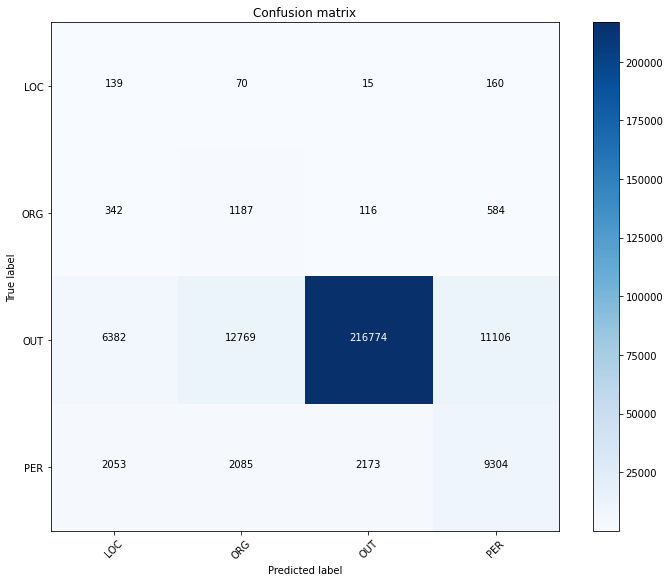

In [27]:
cnf_matrix = confusion_matrix(df_words.nltk_tags, df_words.tag)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['LOC', 'ORG', 'OUT', 'PER'],
                      title='Confusion matrix')

Ну на матрице визуально видно то же самое, что и из отчета классификации.

## SPACY

In [10]:
!pip install -U spacy
!python -m spacy info

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2022-08-26 07:30:04.853744: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

============================== Info about spaCy ==============================

spaCy version    3.4.1                         
Location         /usr/local/lib/python3.7/dist-packages/spacy
Platform         Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic
Python version   3.7.13                        
Pipelines        en_core_web_sm (3.4.0)        



In [24]:
!python -m spacy download ru_core_news_md

2022-08-26 07:44:17.177548: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41.9 MB 1.8 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_md')


Я не смог разобраться, как в spacy сделать отчет классификации и вывод предсказанного таргета для построения confusion matrix.

Поэтому просто визуально оценим ее работу по первой статье:

In [21]:
import spacy
from spacy import displacy

In [23]:
records = load_ne5(dir)
document = next(records).text
nlp = spacy.load('ru_core_news_md')
doc = nlp(document)

displacy.render(doc, jupyter=True, style="dep")
displacy.render(doc, jupyter=True, style="ent")

В целом неплохо, но в этом примере имя часто путается с организацией

## NN

In [10]:
df_words.head(10)

,word,tag
0,Журналист,OUT
1,Олег,PER
2,Кашин,PER
3,уволен,OUT
4,из,OUT
5,"""",OUT
6,Коммерсанта,ORG
7,"""",OUT
8,Журналист,OUT
9,Олег,PER


In [11]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D, GRU, LSTM, Dropout, Input
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [12]:
from sklearn import model_selection, preprocessing, linear_model

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df_words['word'], df_words['tag'])

# labelEncode целевую переменную
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [19]:
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

train_data = train_data.batch(16)
valid_data = valid_data.batch(16)

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
def custom_standardization(input_data):
        return input_data

def data_prep(train_data, seq_len=1, vocab_size = 30000):    
    
    vocab_size = 30000
    #seq_len = 1

    vectorize_layer = TextVectorization(
        standardize=custom_standardization,
        max_tokens=vocab_size,
        output_mode='int',
        output_sequence_length=seq_len)


    # Make a text-only dataset (no labels) and call adapt to build the vocabulary.
    text_data = train_data.map(lambda x, y: x)
    vectorize_layer.adapt(text_data)
    return vectorize_layer

In [16]:
embedding_dim = 64

class modelNER(tf.keras.Model):
    def __init__(self):
        super(modelNER, self).__init__()
        self.emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gPool = tf.keras.layers.GlobalMaxPooling1D()
        self.fc1 = tf.keras.layers.Dense(300, activation='relu')
        self.fc2 = tf.keras.layers.Dense(50, activation='relu')
        self.fc3 = tf.keras.layers.Dense(len(df_words['tag'].value_counts()), activation='softmax')

    def call(self, x):
        x = vectorize_layer(x)
        x = self.emb(x)
        pool_x = self.gPool(x)
        
        fc_x = self.fc1(pool_x)
        fc_x = self.fc2(fc_x)
        
        concat_x = tf.concat([pool_x, fc_x], axis=1)
        return self.fc3(concat_x)

In [60]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report


class Metrics(Callback):


    def on_epoch_end(self, epoch, logs=None):
        val_predict = model.predict(valid_data).argmax(axis=1)
        print('\n', classification_report(valid_y, val_predict, target_names=encoder.classes_))
        cnf_matrix = confusion_matrix(val_predict, valid_y)
        plt.figure(figsize=(10, 8))
        plot_confusion_matrix(cnf_matrix, classes=encoder.classes_,
                              title='Confusion matrix')
        


Обучим 3 сетки подставляя один токен, а также 3 и 5:

Epoch 1/2
12425/12432 [============================>.] - ETA: 0s - loss: 0.2611 - accuracy: 0.9203
               precision    recall  f1-score   support

         LOC       0.92      0.75      0.83      2215
         ORG       0.86      0.59      0.70      4037
         OUT       0.94      0.99      0.97     54777
         PER       0.97      0.71      0.82      5274

    accuracy                           0.94     66303
   macro avg       0.92      0.76      0.83     66303
weighted avg       0.94      0.94      0.93     66303

Confusion matrix, without normalization
12432/12432 [==============================] - 68s 5ms/step - loss: 0.2611 - accuracy: 0.9203 - val_loss: 0.1892 - val_accuracy: 0.9395
Epoch 2/2
12431/12432 [============================>.] - ETA: 0s - loss: 0.1119 - accuracy: 0.9649
               precision    recall  f1-score   support

         LOC       0.91      0.82      0.86      2215
         ORG       0.90      0.59      0.71      4037
         OUT       0.94   

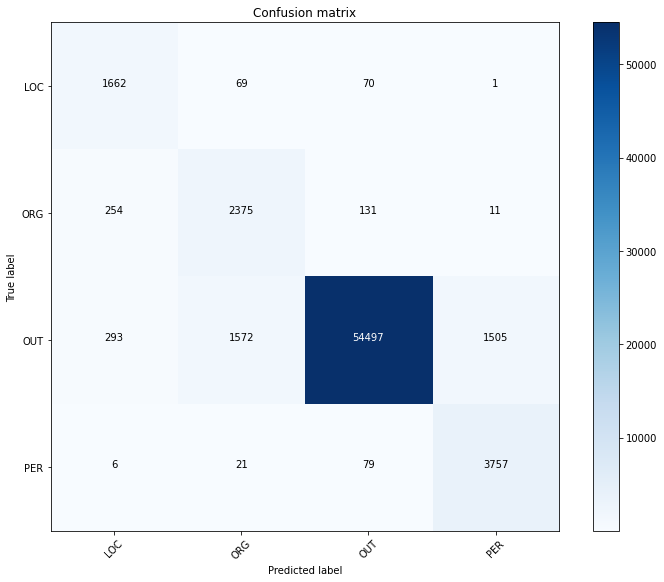

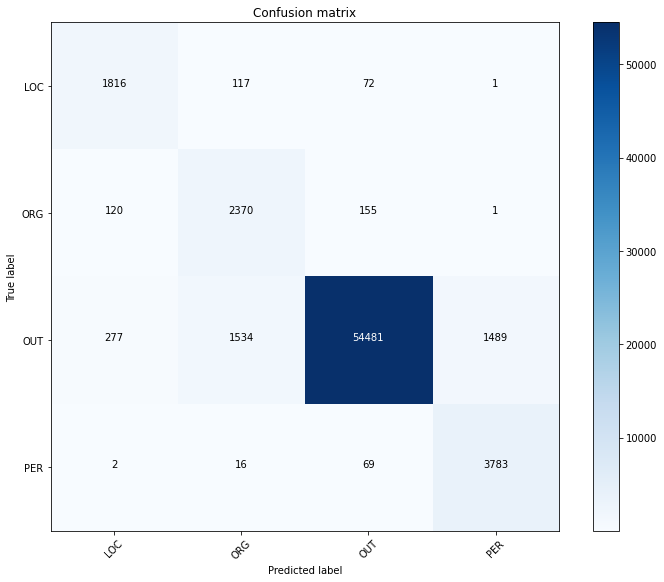

In [61]:
vocab_size = 30000
vectorize_layer = data_prep(train_data, seq_len = 1, vocab_size = vocab_size)


model = modelNER()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.fit(train_data, validation_data=valid_data, epochs=2, callbacks=[Metrics()])

Epoch 1/2
12429/12432 [============================>.] - ETA: 0s - loss: 0.2677 - accuracy: 0.9178
               precision    recall  f1-score   support

         LOC       0.89      0.76      0.82      2215
         ORG       0.85      0.58      0.69      4037
         OUT       0.94      0.99      0.97     54777
         PER       0.98      0.70      0.82      5274

    accuracy                           0.94     66303
   macro avg       0.92      0.76      0.83     66303
weighted avg       0.94      0.94      0.93     66303

Confusion matrix, without normalization
12432/12432 [==============================] - 66s 5ms/step - loss: 0.2677 - accuracy: 0.9178 - val_loss: 0.1935 - val_accuracy: 0.9382
Epoch 2/2
12425/12432 [============================>.] - ETA: 0s - loss: 0.1139 - accuracy: 0.9648
               precision    recall  f1-score   support

         LOC       0.90      0.85      0.87      2215
         ORG       0.91      0.59      0.71      4037
         OUT       0.94   

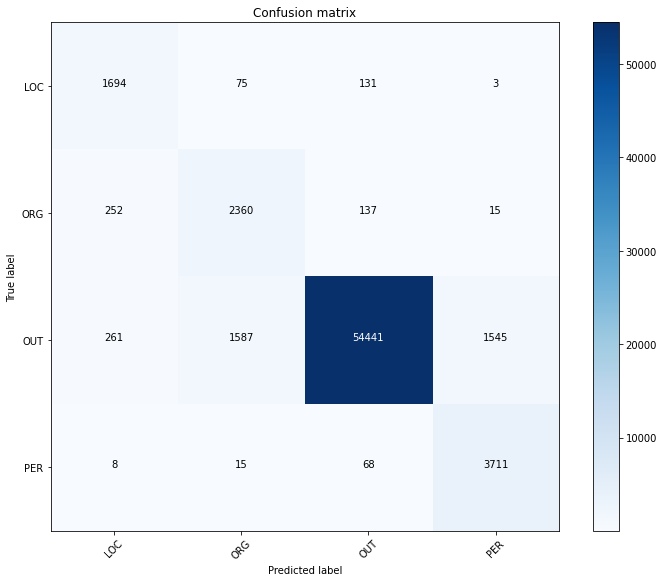

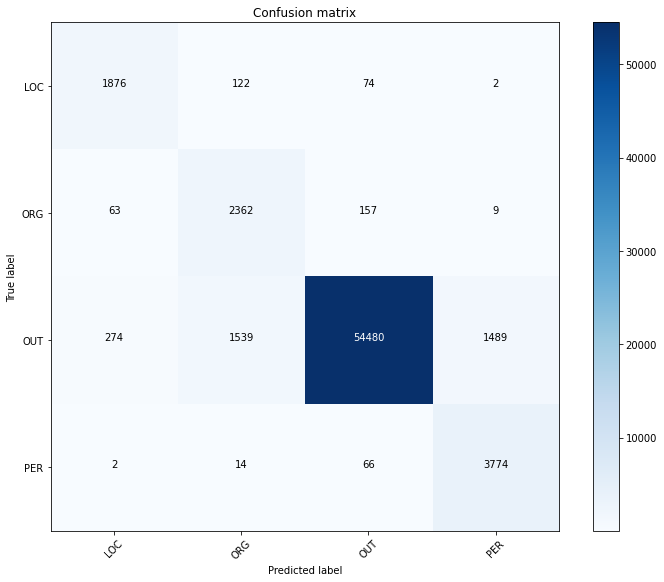

In [62]:
vectorize_layer = data_prep(train_data, seq_len = 3, vocab_size = vocab_size)


model = modelNER()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
hist = model.fit(train_data, validation_data=valid_data, epochs=2, callbacks=[Metrics()])

Epoch 1/2
12423/12432 [============================>.] - ETA: 0s - loss: 0.2687 - accuracy: 0.9175
               precision    recall  f1-score   support

         LOC       0.92      0.74      0.82      2215
         ORG       0.86      0.58      0.69      4037
         OUT       0.94      0.99      0.97     54777
         PER       0.97      0.71      0.82      5274

    accuracy                           0.94     66303
   macro avg       0.92      0.76      0.83     66303
weighted avg       0.94      0.94      0.93     66303

Confusion matrix, without normalization
12432/12432 [==============================] - 67s 5ms/step - loss: 0.2687 - accuracy: 0.9175 - val_loss: 0.1915 - val_accuracy: 0.9385
Epoch 2/2
12426/12432 [============================>.] - ETA: 0s - loss: 0.1142 - accuracy: 0.9645
               precision    recall  f1-score   support

         LOC       0.91      0.84      0.87      2215
         ORG       0.34      0.69      0.46      4037
         OUT       0.97   

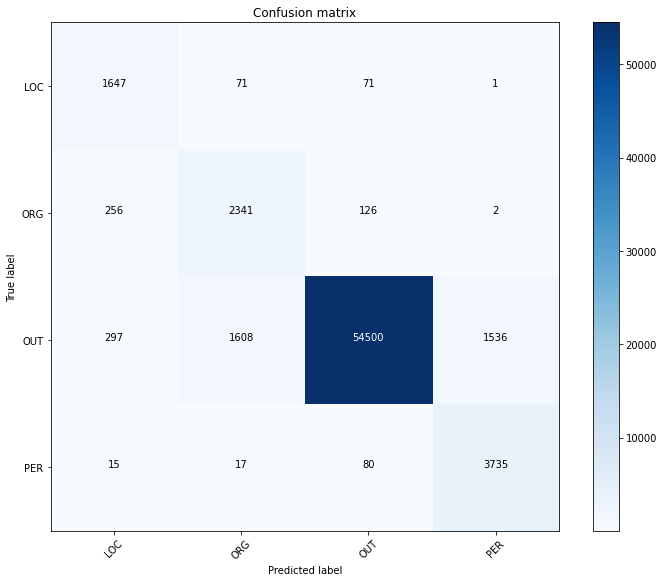

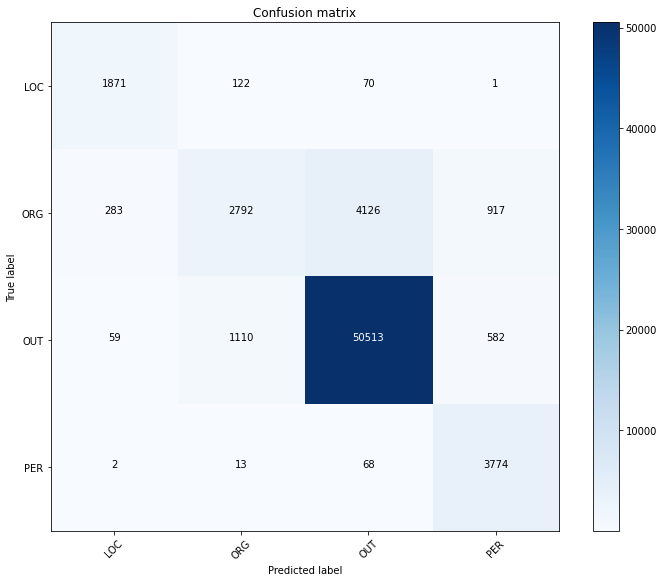

In [63]:
vocab_size = 30000
vectorize_layer = data_prep(train_data, seq_len = 5, vocab_size = vocab_size)


model = modelNER()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
hist = model.fit(train_data, validation_data=valid_data, epochs=2, callbacks=[Metrics()])

**Выводы:**
- количество токенов особо не влияет на качество классификации. Только при 5 токенах сеть на второй эпохе переобучилась и качество упало.
- Результаты достаточно неплохие. По сравнению с nltk - точно.
- Хуже всего сеть определяет организации.

P.S. Насчет deeppavlov, Роман говорил, что можно его не брать из-за очень медленной его работы.